In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/MaskDetection.zip'  # Update if different
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: /content/dataset


In [3]:
train_dir = '/content/dataset/MaskDetection/dataset/train'
val_dir = '/content/dataset/MaskDetection/dataset/val'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='binary'  # Since you have two classes (mask, no_mask)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 3273 images belonging to 2 classes.
Found 819 images belonging to 2 classes.


In [6]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze all layers in the base model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
from tensorflow.keras.layers import BatchNormalization

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)         # ✅ Normalize pooled features
x = Dropout(0.5)(x)                 # Regularization
x = Dense(128, activation='relu')(x)  # Optional dense layer for richer representation
x = BatchNormalization()(x)        # ✅ Normalize before final output
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output

model = Model(inputs=base_model.input, outputs=predictions)


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [10]:
history = model.fit(
    train_generator,
    epochs=15,  # You can increase this
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 39/103 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - accuracy: 0.5823 - loss: 0.9087

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 68s 532ms/step - accuracy: 0.6723 - loss: 0.7075 - val_accuracy: 0.9573 - val_loss: 0.1709
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.9061 - loss: 0.2350 - val_accuracy: 0.9731 - val_loss: 0.1054
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 429ms/step - accuracy: 0.9409 - loss: 0.1593 - val_accuracy: 0.9744 - val_loss: 0.0832
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.9427 - loss: 0.1496 - val_accuracy: 0.9768 - val_loss: 0.0720
Epoch 5/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 429ms/step - accuracy: 0.9466 - loss: 0.1407 - val_accuracy: 0.9792 - val_loss: 0.0667
Epoch 6/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 45s 436ms/step - accuracy: 0.9542 - loss: 0.1088 - val_accuracy: 0.9805 - val_loss: 0.0613
Epoch 7/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.9637 - loss: 0.0962 - val_accuracy: 0.9805 - val_loss: 0.0601
Epoch 8/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.9577 - loss: 0.1113 - val

In [11]:
!nvidia-smi


Wed May  7 13:36:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             30W /   70W |    1142MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

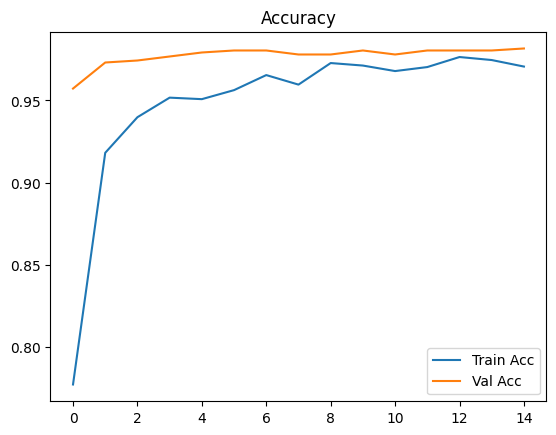

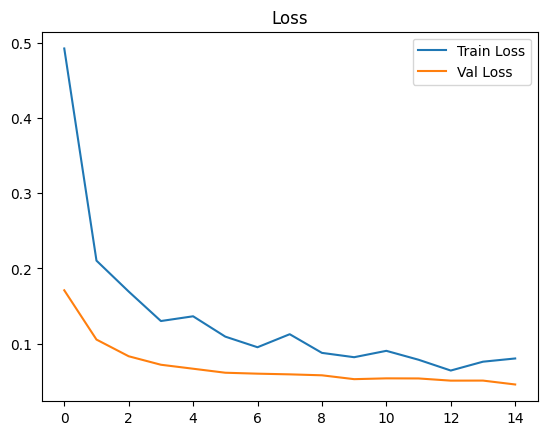

In [12]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [13]:
!pip install opencv-python-headless


In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [18]:
model.save('/content/dataset/MaskDetection/mask_classifier_model.keras')


In [19]:
from tensorflow.keras.models import load_model

model = load_model('/content/dataset/MaskDetection/mask_classifier_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [26]:
def detect_and_classify(image_path):
    image = cv2.imread(image_path)
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected!")
    else:
        print(f"Found {len(faces)} face(s)!")

    # Loop through all detected faces
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (224, 224))  # Resize to model's input size
        face_array = img_to_array(face_resized)  # Convert to array
        face_array = face_array / 255.0  # Normalize
        face_array = np.expand_dims(face_array, axis=0)  # Add batch dimension

        # Predict mask/no mask
        pred = model.predict(face_array)[0][0]
        label = "Mask" if pred < 0.5 else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Draw bounding box and label
        cv2.putText(orig, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.rectangle(orig, (x, y), (x + w, y + h), color, 2)

    # Convert BGR to RGB for displaying in matplotlib
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(orig_rgb)
    plt.axis('off')
    plt.show()


Found 1 face(s)!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


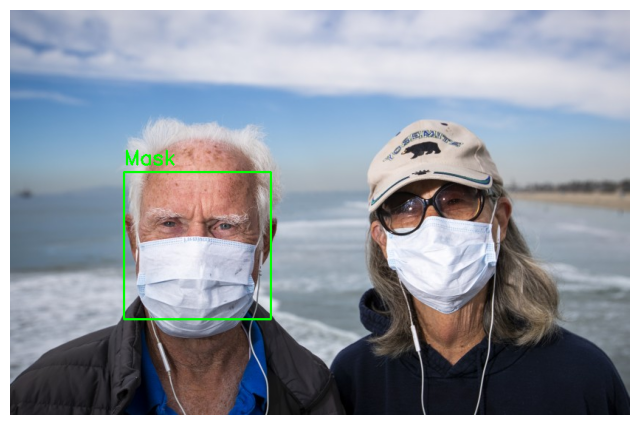

In [27]:
detect_and_classify('pic1.jpeg')

Found 1 face(s)!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


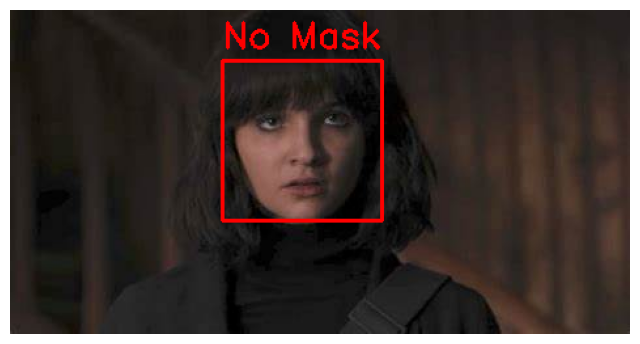

In [28]:
detect_and_classify('pic3.jpg')

Found 3 face(s)!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


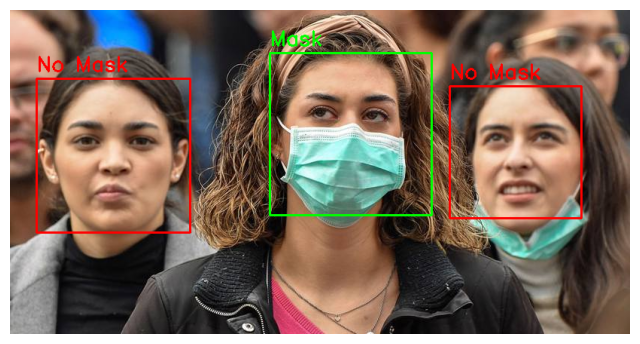

In [29]:
detect_and_classify('pic2.jpg')